# Laboratory Practice: Optional part, pre-trained Model

------------------------------------------------------
*Pablo Gradolph Oliva*

*Raquel Parajuá Delgado*

------------------------------------------------------

## 1. Introduction

We will use a pre-trained model provided by PyTorch, such as ResNet, as an example. This process involves loading a pre-trained model, replacing its last classification layer to fit your specific task (in this case, classifying between birds and cats), and then training only this last layer.

When we use a pre-trained model, such as ResNet, on specific tasks other than those it was originally trained for (in this case, bird vs. cat classification on the CIFAR10 dataset), we generally follow a fine-tuning process. This involves two main steps:

- Transfer Learning: We load the pre-trained model and optionally freeze the weights of some or all of the previous layers so that they are not updated during training. This is useful because the initial layers of a vision model capture general features (such as edges, shapes, etc.) that are applicable to a wide variety of computer vision tasks.

- Fine-Tuning: We tune the last layers of the model (or the entire model, depending on the chosen strategy) to our specific data set. This allows the model to adapt its weights to the particularities of our specific problem.

Although the model comes pre-trained (i.e., it has already learned a set of useful features from a large data set like ImageNet), fine-tuning is necessary because the data set and the specific task (bird vs. cat classification) may differ significantly from the original 1000-class classification task for which it was trained. By training (or retraining) the model on our specific data set, we allow it to tune its parameters to improve its performance on our specific task.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import random_split
from torchvision.datasets import CIFAR10
from torchvision import datasets

For this case we have used the Google Colab GPU which has allowed us to execute this entire part much faster. That's why it's a different notebook.

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available. Training on CPU...")
else:
    print("CUDA is available. Training on GPU...")

CUDA is available. Training on GPU...


## 2. Loading and adjusting data

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# Transformaciones para el conjunto de entrenamiento y validación
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización para ResNet
])

# Transformaciones para el conjunto de prueba
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Cargar el conjunto de datos CIFAR10
train_data_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Filtrar para obtener solo pájaros (2) y gatos (3), y ajustar las etiquetas
def filter_and_adjust_labels(dataset):
    indices = [i for i, (_, label) in enumerate(dataset) if label in [2, 3]]
    subset = Subset(dataset, indices)
    for i in indices:
        dataset.targets[i] = 0 if dataset.targets[i] == 2 else 1
    return subset

train_data = filter_and_adjust_labels(train_data_full)
test_data = filter_and_adjust_labels(test_data_full)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# DataLoaders
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

100%|██████████| 170498071/170498071 [00:13<00:00, 13026120.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 3. ResNet50 model

The process we carry out is exactly the same as that of the first notebook with the difference that here we load the resNet50 model, substantially more complex than the one we have created, to see if there are notable differences.

In [4]:
import torchvision.models as models

# Load pretrained ResNet
model = models.resnet50(pretrained=True)

# Freeze all model parameters to prevent them from updating during training
for param in model.parameters():
    param.requires_grad = False

# Modify the last classification layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


In [5]:
# Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate the model on the validation set
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Validation Loss: {valid_loss / len(valid_loader)}, Accuracy: {100 * correct / total}%')


Epoch 1, Loss: 0.49087092619389294, Validation Loss: 0.3804515054821968, Accuracy: 83.35%
Epoch 2, Loss: 0.4566175853088498, Validation Loss: 0.3649859274923801, Accuracy: 83.8%
Epoch 3, Loss: 0.4404752865806222, Validation Loss: 0.40823520690202714, Accuracy: 81.85%
Epoch 4, Loss: 0.4527178518846631, Validation Loss: 0.37863129198551176, Accuracy: 82.45%
Epoch 5, Loss: 0.42833006124943496, Validation Loss: 0.38594616785645486, Accuracy: 83.15%
Epoch 6, Loss: 0.4362824169546366, Validation Loss: 0.36075037136673926, Accuracy: 84.2%
Epoch 7, Loss: 0.42521437333896756, Validation Loss: 0.38627439305186273, Accuracy: 82.85%
Epoch 8, Loss: 0.43882626689970494, Validation Loss: 0.3614431969076395, Accuracy: 83.3%
Epoch 9, Loss: 0.41178905352950096, Validation Loss: 0.3721263059973717, Accuracy: 83.1%
Epoch 10, Loss: 0.40410396955907346, Validation Loss: 0.39396213918924333, Accuracy: 81.75%


We see how the trained model acts on a test set

In [6]:
from sklearn.calibration import calibration_curve

test_loss = 0.0
total = 0
correct = 0

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss / len(test_loader.dataset)}')
print(f'Test Accuracy: {100 * correct / total}%')

Test Loss: 0.2797390646487474
Test Accuracy: 88.55%


## 3. Reliability Diagram and Expected Calibration Error (ECE)

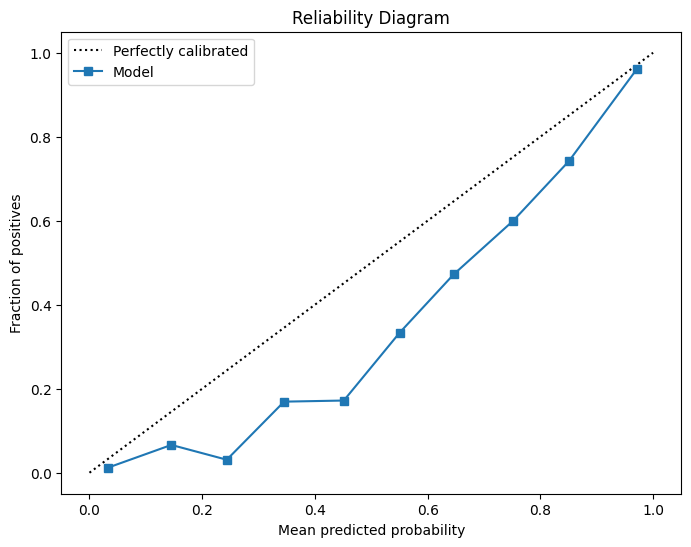

ECE: 0.142960


In [7]:
model.eval()
probs_list = []
labels_list = []

# Function to calculate the ECE using the calibration curve technique
def calculate_ece_with_calibration_curve(probs, labels, n_bins=10):
    fraction_of_positives, mean_predicted_value = calibration_curve(labels, probs, n_bins=n_bins, strategy='uniform')
    ece = np.abs(fraction_of_positives - mean_predicted_value).mean()
    return ece

# Iterate over test data to compile probabilities and true labels.
with torch.no_grad():
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # We use softmax to convert logits into probabilities.
        probabilities = F.softmax(output, dim=1)
        # Here we are assuming that the model has 2 classes and we take the second column, i.e. the class 'cat'.
        cat_probs = probabilities[:, 1]
        probs_list.extend(cat_probs.cpu().numpy())
        labels_list.extend(target.cpu().numpy())

# Convert lists to numpy arrays for use with scikit-learn
probs = np.array(probs_list)
labels = np.array(labels_list)

# Calculating the calibration curve and ECE
prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)
ece_before_scaling = calculate_ece_with_calibration_curve(probs, labels, n_bins=10)

# Mostrar el diagrama de fiabilidad
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Model')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram')
plt.legend()
plt.show()

print(f'ECE: {ece_before_scaling:.6f}')

An ECE of 0.142960 like the one we have indicates that, on average, the difference between the predicted and observed probability is about 14.3%. Slightly higher than our own model, possibly due to the higher complexity of resNet50

## 4. Platt's Scaling

First we are going to load the logits and their labels, and apply Platt's Scaling with a parameter 'a' = 1, in such a way that we should not see changes in either the diagram or the ECE

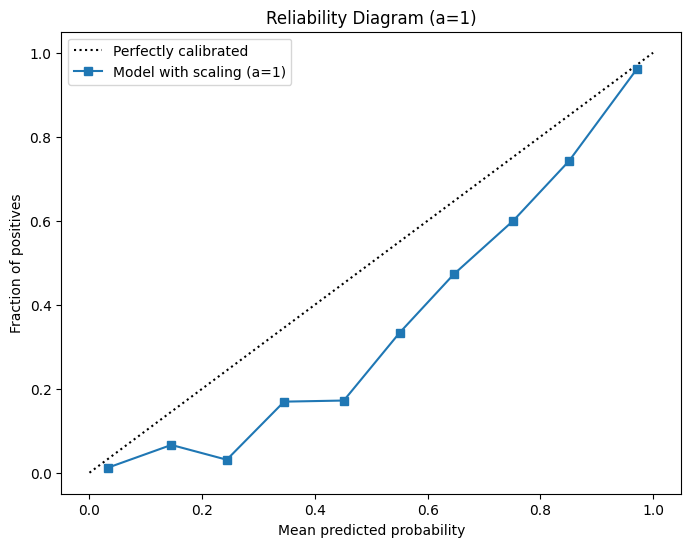

ECE with scaling (a=1): 0.142960


In [8]:
model.eval()
valid_logits_list = []
test_logits_list = []
valid_labels_list = []
test_labels_list = []

with torch.no_grad():
    # For the test set
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        logits = model(data)
        test_logits_list.append(logits.cpu().numpy())
        test_labels_list.append(target.cpu().numpy())

# Convert lists to numpy arrays
test_logits = np.concatenate(test_logits_list, axis=0)
test_labels = np.concatenate(test_labels_list, axis=0)

from scipy.special import softmax

# Calculate probabilities using softmax without logit scaling
probs_scaling = softmax(test_logits, axis=1)

# Calculate ECE and draw the reliability diagram for a=1
ece_after_scaling = calculate_ece_with_calibration_curve(probs_scaling[:, 1], test_labels, n_bins=10)
fraction_of_positives, mean_predicted_value = calibration_curve(test_labels, probs_scaling[:,1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Model with scaling (a=1)')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (a=1)')
plt.legend()
plt.show()

print(f'ECE with scaling (a=1): {ece_after_scaling:.6f}')

Now we will try to find the best possible value for the parameter a and calculate the ECE and the diagram for this calculated value of a.

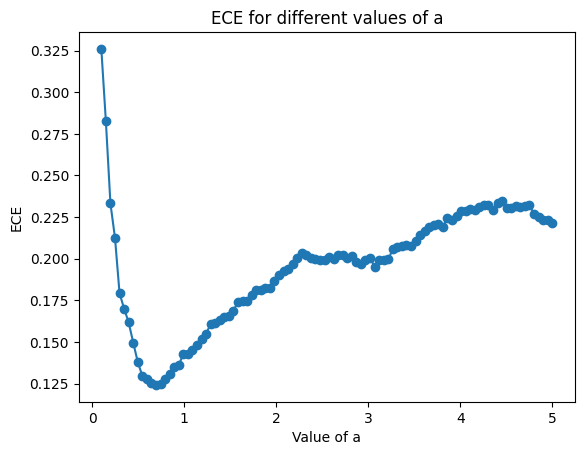

Best a: 0.693939393939394 with ECE: 0.124285


In [9]:
a_values = np.linspace(0.1, 5.0, 100)
ece_values = []

for a in a_values:
    scaled_logits = test_logits * a  # We use multiplication because a is the inverse of T

    # Calculate scaled probabilities using softmax
    scaled_probs = softmax(scaled_logits, axis=1)

    # Calculate the ECE for scaled probabilities
    ece_after_scaling = calculate_ece_with_calibration_curve(scaled_probs[:, 1], test_labels, n_bins=10)
    ece_values.append(ece_after_scaling)

# Plot the ECE based on the values ​​of a
plt.plot(a_values, ece_values, 'o-')
plt.xlabel('Value of a')
plt.ylabel('ECE')
plt.title('ECE for different values of a')
plt.show()

# Identify the value of a with the lowest ECE
min_ece_index = np.argmin(ece_values)
best_a = a_values[min_ece_index]
print(f"Best a: {best_a} with ECE: {ece_values[min_ece_index]:.6f}")

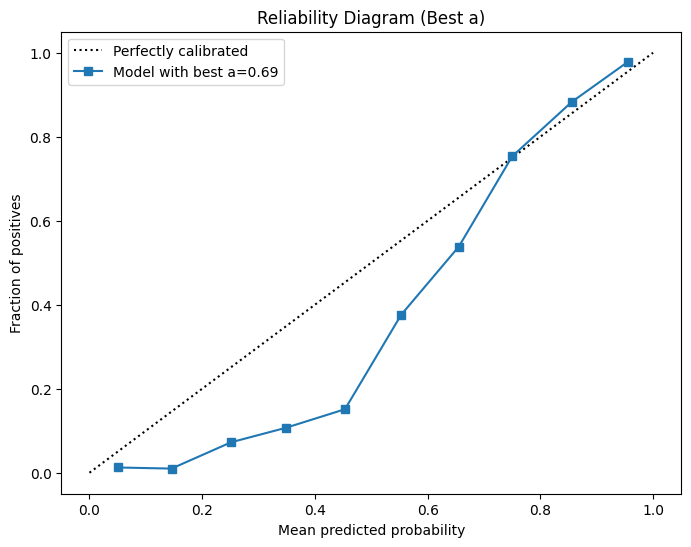

ECE with best a (a=0.69): 0.124285


In [10]:
# Scale the logits by the best value of a found
scaled_logits_best_a = test_logits * best_a

# Calculate scaled probabilities using softmax
scaled_probs_best_a = softmax(scaled_logits_best_a, axis=1)

# Calculate ECE and draw the reliability diagram for the best a
ece_best_a = calculate_ece_with_calibration_curve(scaled_probs_best_a[:, 1], test_labels, n_bins=10)
fraction_of_positives_best_a, mean_predicted_value_best_a = calibration_curve(test_labels, scaled_probs_best_a[:,1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(mean_predicted_value_best_a, fraction_of_positives_best_a, 's-', label=f'Model with best a={best_a:.2f}')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (Best a)')
plt.legend()
plt.show()

print(f'ECE with best a (a={best_a:.2f}): {ece_best_a:.6f}')

## 5. Example of use of the best calibrated model

In [11]:
# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

classes = ['bird', 'cat']

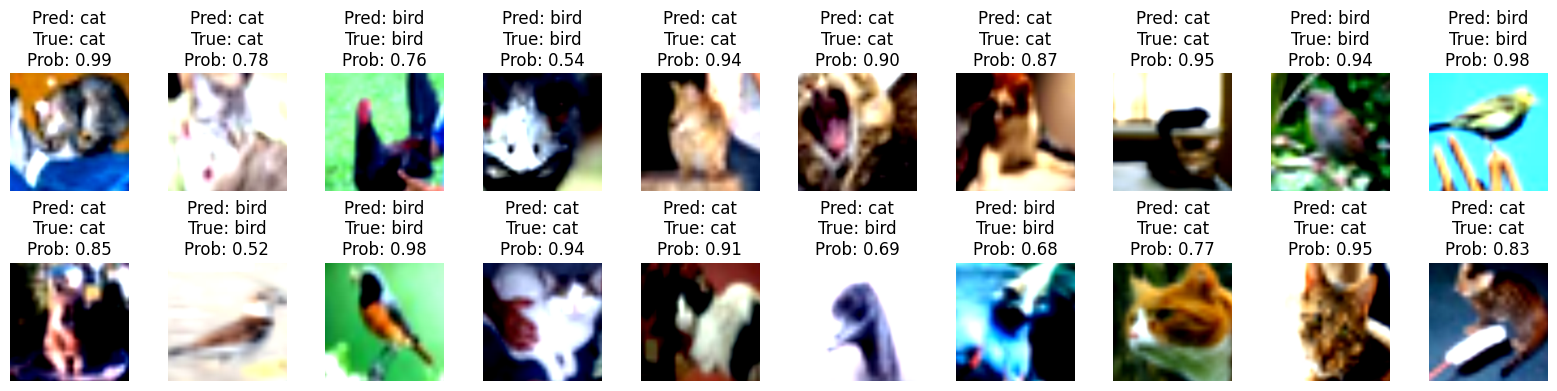

In [12]:
# Select a small set of images to demonstrate the prediction
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move model and images to GPU if available
if torch.cuda.is_available():
    images = images.cuda()
    model.cuda()

model.eval()
with torch.no_grad():
    logits = model(images)
    logits_scaled = logits.cpu().numpy() * best_a  # Apply the calibration factor 'a' to the logits
    probs = softmax(logits_scaled, axis=1)  # Calculate calibrated probabilities using softmax

# Show images and their calibrated probabilities
plt.figure(figsize=(20, 4))
plt.subplots_adjust(hspace=0.6)
for i in range(len(images)):
    ax = plt.subplot(2, len(images)//2, i+1)
    imshow(images[i].cpu())
    predicted_class = np.argmax(probs[i])
    true_class = labels[i].item()
    ax.set_title(f"Pred: {classes[predicted_class]}\nTrue: {classes[true_class]}\nProb: {probs[i][predicted_class]:.2f}")
    plt.axis('off')
plt.show()